In [697]:
# !pip install sentence-transformers xgboost matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [698]:
RANDOM_STATE = 42

#### Load Dataset

In [699]:
df = pd.read_csv("../data/synthetic_users_dataset_2000.csv")
X = df.drop(columns=[
    "severity_score",
    "severity_class"
])
y = df["severity_score"]

In [700]:
from collections import Counter
print(Counter(y))

Counter({2: 500, 3: 454, 4: 413, 1: 400, 5: 233})


In [701]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # maps 1→0, 2→1, ..., 5→4

#### Split the dataset

In [702]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.3,
    stratify=y_encoded,
    shuffle=True,
    random_state=RANDOM_STATE
)

#### Define Transformers

In [703]:
# class BERTVectorizer(BaseEstimator, TransformerMixin):
#     def __init__(self, model_name="all-MiniLM-L6-v2"):
#         self.model_name = model_name
#         self.model = SentenceTransformer(model_name)

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         if isinstance(X, pd.DataFrame):
#             X = X.iloc[:, 0]
#         return self.model.encode(X.tolist(), convert_to_numpy=True)

# transformers = {
#     "TF-IDF (1&2-gram)": TfidfVectorizer(ngram_range=(1, 2), max_features=300),
#     "BoW (1&2-gram)": CountVectorizer(ngram_range=(1, 2), max_features=300),
#     # "BERT Embedding": BERTVectorizer()
# }

#### Define Classifiers

In [704]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=7,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced"
    ),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=RANDOM_STATE),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=8),
    "XGBoost": XGBClassifier(
        eval_metric="mlogloss",
        objective='multi:softmax',  # softmax for multi-classification
        num_class=len(set(y_encoded)),
        max_depth=3,
        learning_rate=0.002,
        random_state=RANDOM_STATE
    ),
}

#### Combinations

In [705]:
# text_features = ["user_input"]
# categorical_features = ["pain_type", "pain_location", "radiates", "duration", "severity_class"]
# ordinal_features = ["self_score"]
categorical_features = X.select_dtypes(include="object").columns.tolist()
ordinal_features = X.select_dtypes(include="number").columns.tolist()

results = []
pipelines = {}
# for tf_name, tf in transformers.items():
for clf_name, clf in classifiers.items():
    # Skip invalid combination
    # if tf_name == "BERT Embedding" and clf_name == "Naive Bayes":
    #     continue

    # pipeline_name = f"{tf_name} + {clf_name}"
    pipeline_name = clf_name
    print(f"🔍 Training: {pipeline_name}")

    # Define column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            # ("text", tf, "user_input"),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
            ("ord", OrdinalEncoder(), ordinal_features)
        ]
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    pipelines[pipeline_name] = pipeline

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results.append({
        "Pipeline": pipeline_name,
        "Accuracy": report["accuracy"],
        "Macro Precision": report["macro avg"]["precision"],
        "Weighted Precision": report["weighted avg"]["precision"],
        "Macro Recall": report["macro avg"]["recall"],
        "Weighted Recall": report["weighted avg"]["recall"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    })


🔍 Training: Logistic Regression
🔍 Training: Random Forest
🔍 Training: SVM (Linear Kernel)
🔍 Training: Naive Bayes
🔍 Training: KNN
🔍 Training: XGBoost


In [706]:
import joblib

# Find the best model
best_result = max(results, key=lambda x: x["Accuracy"])
best_pipeline_name = best_result["Pipeline"]
best_pipeline = pipelines[best_pipeline_name]

# Save model
file_path = "../models/classification_model.pkl"
joblib.dump(best_pipeline, file_path)

print(f"✅ Best model: {best_pipeline_name} with Accuracy = {best_result['Accuracy']:.3f}")
print(f"✅ Model saved to: {file_path}")

✅ Best model: Random Forest with Accuracy = 0.895
✅ Model saved to: ../models/classification_model.pkl


In [707]:
# ---- Show result table ----
results_df = pd.DataFrame(results)
print("\n📊 Evaluation Summary:")
print(results_df.to_string(index=False))


📊 Evaluation Summary:
           Pipeline  Accuracy  Macro Precision  Weighted Precision  Macro Recall  Weighted Recall  Macro F1  Weighted F1
Logistic Regression  0.866667         0.857964            0.866684      0.860676         0.866667  0.858359     0.865710
      Random Forest  0.895000         0.883162            0.895705      0.888380         0.895000  0.883398     0.893059
SVM (Linear Kernel)  0.866667         0.860088            0.867079      0.859485         0.866667  0.858429     0.865449
        Naive Bayes  0.605000         0.633414            0.610196      0.617324         0.605000  0.623810     0.606454
                KNN  0.838333         0.826896            0.841416      0.835708         0.838333  0.826298     0.835147
            XGBoost  0.861667         0.860698            0.872835      0.860680         0.861667  0.853654     0.860552


#### TSNE

In [708]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

def plot_tsne(X_test_vectorized, y_test, y_pred):
  # Standardization + Dimensionality Reduction
  # X_scaled = StandardScaler(with_mean=False).fit_transform(X_test_vectorized)
  # X_dense = PCA(n_components=3).fit_transform(X_scaled)

  # Set perplexity based on sample size
  n_samples = X_test_vectorized.shape[0]
  if n_samples <= 50:
    perplexity = 10
  elif n_samples <= 100:
    perplexity = 15
  elif n_samples <= 500:
    perplexity = 30
  elif n_samples <= 1000:
    perplexity = 50
  else:
    perplexity = 100  # For very large datasets
  # Ensure perplexity is not larger than (n_samples - 1)
  perplexity = min(perplexity, n_samples - 1)

  X_embedded = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=perplexity).fit_transform(X_test_vectorized)

  # Check whether classified correctly
  y_test = np.array(y_test)
  y_pred = np.array(y_pred)
  correct_mask = (y_pred == y_test)

  plt.figure(figsize=(8, 5))

  # Correctly classified: o，misclassified: x
  num_classes = len(np.unique(y_test))
  colors = plt.colormaps.get_cmap("Set1")

  for class_id in range(1, num_classes + 1):
      class_mask = (y_test == class_id)

      # Correctly classified samples
      plt.scatter(
          X_embedded[correct_mask & class_mask, 0],
          X_embedded[correct_mask & class_mask, 1],
          c=[colors(class_id - 1)],
          marker='o',
          label=f"Severity score {class_id} ✓",
          s=30,
          alpha=0.7,
          edgecolors="none"
      )

      # Misclassified samples
      plt.scatter(
          X_embedded[~correct_mask & class_mask, 0],
          X_embedded[~correct_mask & class_mask, 1],
          c=[colors(class_id - 1)],
          marker='x',
          label=f"Severity score {class_id} ✗",
          s=30,
          linewidths=2,
          alpha=0.9
      )

  plt.legend(
      loc='upper left',
      bbox_to_anchor=(1, 1),
      fontsize=10,
      frameon=True
  )
  plt.title("t-SNE visualization of prediction results")
  plt.xlabel("t-SNE dim 1")
  plt.ylabel("t-SNE dim 2")
  plt.grid(True)
  plt.tight_layout()
  plt.show()


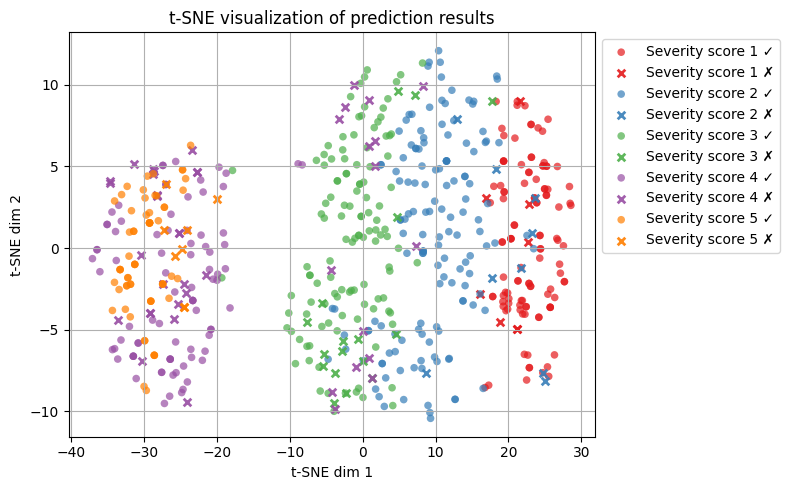

In [709]:
# X_train_vectorized = best_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_vectorized = best_pipeline.named_steps["preprocessor"].transform(X_test)

y_test_label = le.inverse_transform(y_test)
y_pred_label = le.inverse_transform(y_pred)

plot_tsne(X_test_vectorized, y_test_label, y_pred_label)